Running auto_arima to find optimal parameters... This may take a moment.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=250.178, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=250.028, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=250.165, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=351.488, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=248.144, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=250.043, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=252.045, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=250.104, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=246.407, Time=0.14 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=246.940, Time=0.38 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=249.106, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept

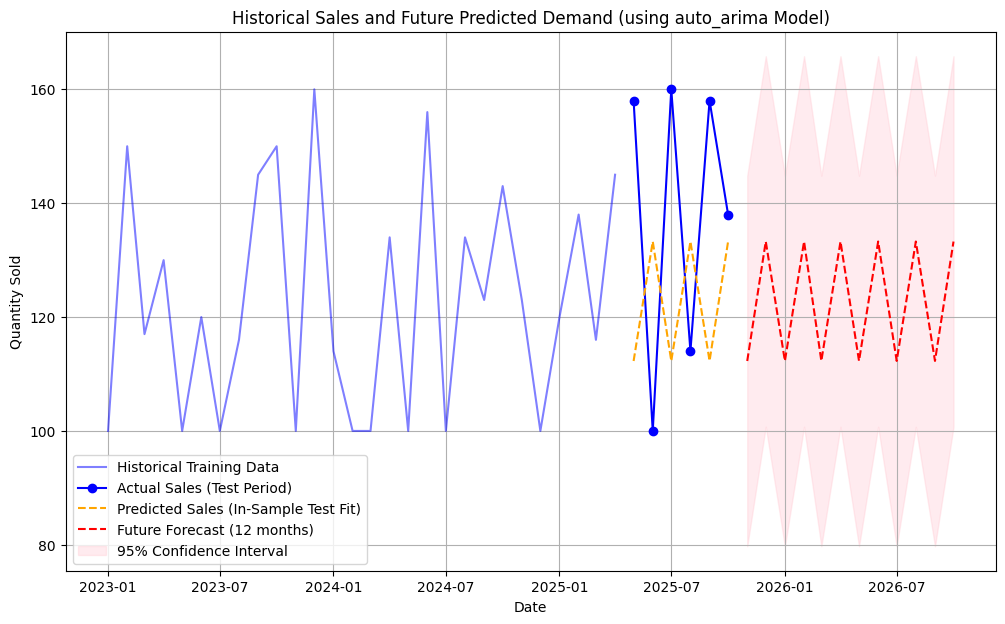

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import pmdarima library
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings that sometimes appear during SARIMA fitting
warnings.filterwarnings("ignore")

# Note: You may need to install pmdarima first: pip install pmdarima

# --- Step 1: Load and Clean Data ---
try:
    data = pd.read_csv('Historical_Sales1.csv')
    df = pd.DataFrame(data)  
except FileNotFoundError:
    print("Error: Historical_Sales.csv not found.")
    exit()

df = df.replace(' ', np.nan)
df['QuantitySold'] = pd.to_numeric(df['QuantitySold'], errors='coerce')
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# --- Step 2: Split Data (Training and Test/Future Period) ---
# We use the last 6 months of historical data for validation/testing
forecast_period = 6 
train_data = df[:-forecast_period]
test_data = df[-forecast_period:]

# --- Step 3: Configure and Fit the Model using auto_arima ---

print("Running auto_arima to find optimal parameters... This may take a moment.")

# The auto_arima function finds the best (p,d,q)x(P,D,Q,s) order automatically
# m=12 specifies a seasonal period of 12 months
auto_model = pm.auto_arima(train_data['QuantitySold'], 
                           seasonal=True, m=12,  
                           trace=True,
                           enforce_stationarity=False, 
                           enforce_invertibility=False,
                           suppress_warnings=True,
                           stepwise=True, # Use stepwise search for efficiency
                           n_jobs=-1)     # Use all available processors

print("\nOptimal SARIMA Model Summary:")
print(auto_model.summary())

# --- Step 4: Generate Predictions (In-sample and Out-of-sample) ---

# Get predictions starting from the beginning of the test period to the end of the test period
# Use the auto_model.predict_in_sample method or the standard predict method
# Using auto_model.predict for future steps beyond the training data
predicted_mean_test = auto_model.predict(n_periods=forecast_period, return_conf_int=False, exogenous=None)
predicted_mean_test.index = test_data.index

# Calculate MSE for validation on the test set
mse = mean_squared_error(test_data['QuantitySold'], predicted_mean_test)
print(f'\nMean Squared Error on Test Data: {mse}')

# Generate *future* forecasts beyond the historical data range
future_forecast_steps = 12
# Use predict with confidence intervals
forecast_mean, forecast_ci = auto_model.predict(n_periods=future_forecast_steps, return_conf_int=True)
# Assign dates to the forecast index
forecast_mean.index = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=future_forecast_steps, freq='MS')
forecast_ci_df = pd.DataFrame(forecast_ci, index=forecast_mean.index, columns=['lower', 'upper'])


# --- Step 5: Visualization ---

plt.figure(figsize=(12, 7))

# Plot training data
plt.plot(train_data.index, train_data['QuantitySold'], label='Historical Training Data', color='blue', alpha=0.5)

# Plot actual test data
plt.plot(test_data.index, test_data['QuantitySold'], label='Actual Sales (Test Period)', color='blue', marker='o')

# Plot in-sample predictions for test period
plt.plot(predicted_mean_test.index, predicted_mean_test, label='Predicted Sales (In-Sample Test Fit)', color='orange', linestyle='--')

# Plot future forecast
plt.plot(forecast_mean.index, forecast_mean, label=f'Future Forecast ({future_forecast_steps} months)', color='red', linestyle='--')

# Plot confidence intervals for the future forecast
plt.fill_between(forecast_ci_df.index,
                 forecast_ci_df['lower'],
                 forecast_ci_df['upper'], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title('Historical Sales and Future Predicted Demand (using auto_arima Model)')
plt.legend()
plt.grid(True)
plt.show()
